In [211]:
!pip install yfinance
!pip install --upgrade ta
!pip install hmmlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29106 sha256=ea9afb3d2df8d7a5cab9885b8d01f0616a39ab80796ca1171e8d07cd66ad4d1d
  Stored in directory: /root/.cache/pip/wheels/31/31/f1/f2ff471bbc5b84a4b973698ceecdd453ae043971791adc3431
Successfully built ta
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 217 kB 6.5 MB/s 


In [384]:
import numpy as np
import pandas as pd
import pytz
from matplotlib import cm, pyplot as plt
from hmmlearn.hmm import GaussianHMM
import scipy
import datetime
import json
import seaborn as sns
import yfinance as yf
import ta
import pickle

sns.set_palette(sns.color_palette('bright'))

In [241]:
start = '2000-01-01'
tend = '2019-12-31'
vstart = '2020-01-01'
vend = '2020-12-31'
tstart = '2021-01-01'
end = '2022-11-30'
interval = '1d'
path = 'drive/MyDrive/csvs/'

In [ ]:
def read_og(path):
    df = pd.read_csv(path)
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date', ascending=True).reset_index(drop=True)
    df['Close'] = df['Close'].replace(',', '', regex=True)
    df['Close'] = df['Close'].replace('-', '0')
    df['Close'] = df['Close'].astype(np.float32)
    return df

def join_og(path1, path2):
    df1 = read_og(path1)
    df2 = read_og(path2)
    df = df1.merge(df2, on='Date')
    df = df.rename({'Date': 'date'}, axis=1)
    df['gold/oil'] = df['Close_x'] / df['Close_y']
    df = df.drop(['Close_x', 'Close_y'], axis=1).set_index('date')
    return df.reset_index(drop=True)

In [ ]:
df = join_og('gold2.csv', 'oil.csv')
df.to_csv('og.csv')

In [ ]:
bond = pd.read_csv("1-year-treasury-rate-yield-chart.csv", parse_dates=['date'])
bdays = pd.bdate_range('2003-10-16', '2022-11-28')
bond = bond[bond['date'].isin(bdays)]

df = df.merge(bond, on='date', how='outer').sort_values('date').reset_index(drop=True)
df = df.rename({' value': '1Y_bond'}, axis=1)

df.to_csv('plain.csv')
df = df.fillna(method='ffill')
df.to_csv('filled.csv')

In [ ]:
def mas(path):
    df = pd.read_csv(path, usecols=['time', 'close'])
    df['time'] = pd.to_datetime(df['time'], unit='s')
    df['time'] = df['time'].dt.normalize()
    df.columns = ['date', '%50da']
    return df.set_index('date')

,gold/oil,1Y_bond,%50da,%20da
date,,,,
2003-10-16,12.118644,1.34,79.25,74.60
2003-10-17,12.118644,1.31,75.05,66.57
2003-10-19,12.322900,1.31,75.05,66.57
2003-10-20,12.647449,1.32,74.64,67.48
2003-10-21,12.917781,1.32,75.35,69.65
...,...,...,...,...
2022-11-22,21.473751,4.79,67.83,65.57
2022-11-23,22.387733,4.75,69.61,66.74
2022-11-24,22.387733,4.75,69.61,66.74


In [ ]:
ma = mas('MMFI.csv')
ma2 = mas('MMTW.csv')
ma = ma.merge(ma2, on='date')
ma.to_csv('mas.csv')

df = df.merge(ma, on='date', how='left').fillna(method='ffill')
df.to_csv('filled.csv')

,%50da,%20da
date,,
2003-02-05,39.16,31.96
2003-02-06,37.76,29.61
2003-02-07,34.44,27.32
2003-02-10,35.68,29.21
2003-02-11,34.79,28.83
...,...,...
2022-11-22,67.83,65.57
2022-11-23,69.61,66.74
2022-11-25,70.48,67.20


In [ ]:
vix = yf.Ticker('^VIX').history(period='max')
vix = vix.reset_index()
vix['Date'] = pd.to_datetime(vix['Date'].dt.date)
vix = vix[['Date', 'Close']]
vix.columns = ['date', 'vix']
vix = vix.set_index('date')
vix.to_csv('drive/MyDrive/csvs/vix.csv')

In [ ]:
df = df.merge(vix, on='date', how='left').fillna(method='ffill')

In [190]:
pcr = pd.read_csv('pcr.csv', header=None)
pcr.columns = ['date', 'PCR', 2, 2, 2]
pcr = pcr.drop(2,axis=1)
pcr['date'] = pd.to_datetime(pcr['date'])
pcr.to_csv('pcr.csv')

In [200]:
df = df.merge(pcr.set_index('date'), left_index=True, right_index=True)
df.to_csv('drive/MyDrive/csvs/filled.csv')

In [214]:
dj = yf.download('^DJI', '2000-01-01', '2022-11-30', interval='1d')
dj.to_csv(path+'dji.csv')
dj.columns = ['open', 'high', 'low', 'close', 'adjclose', 'volume']
dj.index.names = ['date']
dj = dj.drop('adjclose', axis=1)
dj

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,volume
date,,,,,
2000-01-03,11501.849609,11522.009766,11305.690430,11357.509766,169750000
2000-01-04,11349.750000,11350.059570,10986.450195,10997.929688,178420000
2000-01-05,10989.370117,11215.099609,10938.669922,11122.650391,203190000
2000-01-06,11113.370117,11313.450195,11098.450195,11253.259766,176550000
2000-01-07,11247.059570,11528.139648,11239.919922,11522.559570,184900000
...,...,...,...,...,...
2022-11-22,33810.050781,34115.699219,33810.050781,34098.101562,277070000
2022-11-23,34091.570312,34262.070312,34004.640625,34194.058594,236820000
2022-11-25,34213.039062,34386.511719,34199.570312,34347.031250,131660000


In [234]:
dj['cci'] = ta.trend.CCIIndicator(dj['high'], dj['low'], dj['close']).cci()
dj['mi'] = ta.trend.MassIndex(dj['high'], dj['low']).mass_index()
dj['rsi'] = ta.momentum.RSIIndicator(dj['close']).rsi()
dj['don'] = ta.volatility.DonchianChannel(dj['high'], dj['low'], dj['close']).donchian_channel_pband()

dj['12w_return'] = dj['close'].pct_change(21*3)
dj['4w_return'] = dj['close'].pct_change(21)
dj['return'] = dj['close'].pct_change()

In [239]:
df = df.merge(dj, left_index=True, right_index=True, how='left')
df['gold/oil'] = df['gold/oil'].replace(np.inf, np.nan).fillna(method='ffill')
df.to_csv(path+'feng.csv')
df = df.drop(['open', 'high', 'low', 'close', 'volume'], axis=1)

In [357]:
train = df.loc[:tend]
val = df.loc[vstart:vend]
test = df.loc[tstart:end]

In [264]:
def ics(LL, n_params, sample_size):
    bic_k = np.log(sample_size)
    aic_k = 2
    bic = (bic_k*n_params) - 2*LL
    aic = (aic_k*n_params) - 2*LL
    return aic, bic

In [299]:
scores = {}
for states in range(1, 10):
    hmm_model = GaussianHMM(
        n_components=states,
        #random_state=42,
        covariance_type='diag',
        n_iter=1000000,
        tol=0.001
        ).fit(train.values)

    score = hmm_model.score(train.values)
    scores[states] = score

In [300]:
aics, bics = {}, {}
for k, v in scores.items():
    aic, bic = ics(v, k, train.shape[0])
    aics[k] = aic
    bics[k] = bic

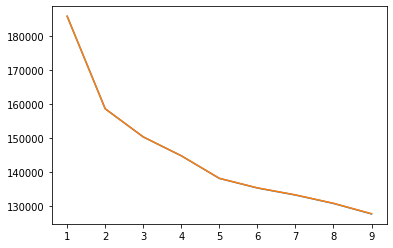

In [301]:
plt.plot(list(aics.keys()), list(aics.values()))
plt.plot(list(bics.keys()), list(bics.values()))

In [356]:
hmm_model = GaussianHMM(
    n_components=3,
    #random_state=42,
    covariance_type='diag',
    n_iter=1000000,
    tol=0.001
    ).fit(df.drop('close', axis=1).values)
    #(train[['gold/oil', '1Y_bond', '%50da', '%20da', 'vix', 'PCR']].values)

probas = hmm_model.predict_proba(df.drop('close', axis=1).values)
labels = hmm_model.predict(df.drop('close', axis=1).values) #train[['gold/oil', '1Y_bond', '%50da', '%20da', 'vix', 'PCR']].values)
df.loc[:, 'regime'] = labels
probas

array([[1.00000000e+000, 0.00000000e+000, 4.00542860e-258],
       [9.99964487e-001, 2.41539049e-014, 3.55129874e-005],
       [9.99999293e-001, 3.04145793e-016, 7.07265448e-007],
       ...,
       [1.00000000e+000, 9.49184743e-018, 9.64502014e-012],
       [1.00000000e+000, 7.98231270e-019, 4.20241889e-013],
       [9.99973340e-001, 1.77302907e-010, 2.66595239e-005]])

In [340]:
pd.concat([train.groupby('regime').std()[['12w_return', '4w_return', 'cci', 'mi', 'rsi', 'don']], train.groupby('regime').mean()[['12w_return', '4w_return', 'cci', 'mi', 'rsi', 'don']]])

,12w_return,4w_return,cci,mi,rsi,don
regime,,,,,,
0,0.043905,0.029132,102.545863,1.515447,11.432201,0.279209
1,0.070794,0.043797,110.829094,1.189363,11.231635,0.309931
2,0.057895,0.024664,45.526278,0.987408,5.653321,0.098629
0,0.031816,0.012400,35.721818,24.804728,57.025824,0.675058
1,-0.005198,-0.009308,-16.675584,25.269592,49.455707,0.498797
2,0.058582,0.035866,109.468704,24.469433,63.367795,0.886181


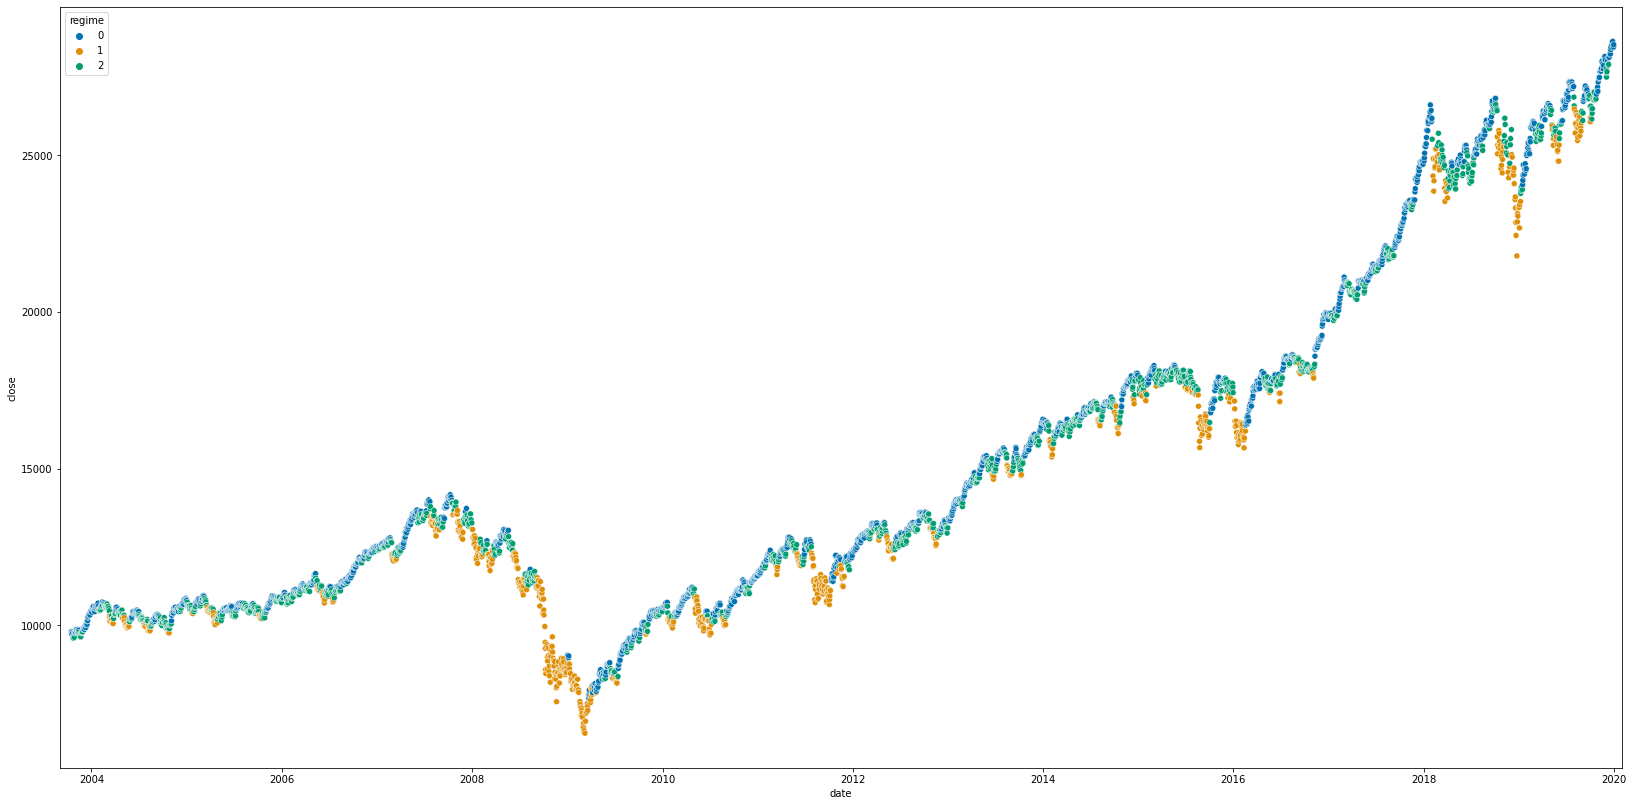

In [383]:
fig, ax = plt.subplots(1, 1, figsize=(28, 14))
sns.scatterplot(data=train, x=train.index,y='close', hue='regime', palette='colorblind', ax=ax)
ax.set_xlim(pd.to_datetime('2003-09-01'), pd.to_datetime('2020-02-01'))
plt.savefig(path+'1_tol0.001_ncomp3.png')
pic_dict[1] = train.columns.tolist()

In [385]:
pickle.dump(pic_dict, open(path+'pic_dict.pkl', 'wb'))